# Extreme Quantile Matching

This code implements the contrast-amplification analysis described in the study's Appendix. This notebook focuses on "extreme" dietary contrasts to uncover stronger physiological signals that might be missed in average comparisons.

#### Matching Pipeline

Pipeline:
1. **Extreme Contrasts:** The pipeline typically compares individuals in the top 30% vs. the bottom 30% of a given exposure distribution (e.g., very high fiber vs. very low fiber).
2. **Matching Strategy:** It performs 1:1 propensity-score matching without replacement.
3. **Caliper Constraints:** A strict caliper of 0.15 standard deviations of the logit of the propensity score is applied. 
4. **Hard Covariates:** The matching explicitly balances for critical structural factors like gender and BMI.

#### Variance Reduction via CUPED

Because extreme-quantile matching results in significantly smaller sample sizes (typically only 200–300 matched pairs), the study uses CUPED (Controlled-experiment Using Pre-Existing Data) to reduce variance and improve statistical power. 

#### Validation

The loop generates a comprehensive meta_log_df to track the health of each "mini-trial": 
1. **Sample Integrity:** Records the number of matched pairs (n_pairs) and unique controls used to ensure the sample is representative.
2. **Balance Diagnostics:** Tracks ASMD (Absolute Standardized Mean Difference) post-matching. 

In [1]:
import warnings
from dataclasses import replace
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

from scripts.helpers import run_experiment
from scripts.matching import *
from scripts.plot import *
from scripts.propensity import get_propensity_scores
from variables.labels import *
from variables.variables import *

warnings.filterwarnings("ignore")

# ================================================================
# Hyperparameters
# ================================================================

cfg = replace(
    BASE_CONFIG,
    method='quantile',
    limit=None,
    quantile=0.3
)
print(f"Running analysis of {cfg.__dict__['quantile']} quantile")

# ================================================================
# Paths
# ================================================================

log_dir = Path(matching_folder_path_quantile)
log_dir.mkdir(parents=True, exist_ok=True)
log_csv_path = log_dir / "matching_meta_log.csv"
df_dir = Path(matching_df_folder_path)
df_dir.mkdir(parents=True, exist_ok=True)
meta_rows = []

# ================================================================
# Loop
# ================================================================

for exposure in tqdm(EXPOSURES):
    df, kwargs, X, shap_values = get_propensity_scores(
        exposure=exposure,
        config=cfg.__dict__,
        variables=variable_config,
        file=DATAFRAME_PATH,
    )
    exposure_baseline = exposure.split("_target_day")[0]
    results_df, matched_df, balance_df, meta = estimate_ate_matching_pipeline_cuped(
        df=df,
        variable_config=variable_config,
        treat_col="treated",
        ps_col="calibrated_scores_logreg",
        match_covariates=["gender", "bmi",], 
        caliper=0.15,
        replace=False,
        alpha=0.05,
        seed=0,
    )
    results_df.to_csv(f"{df_dir}/{exposure_baseline}_results.csv")
    balance_df.to_csv(f"{df_dir}/{exposure_baseline}_balance.csv")

    meta_rows.append({
        "exposure": exposure,
        "exposure_baseline": exposure_baseline,
        "n_pairs": meta.get("n_pairs", pd.NA),
        "mean_abs_SMD_post": meta.get("mean_abs_SMD_post", pd.NA),
        "p75_abs_SMD_post": meta.get("p75_abs_SMD_post", pd.NA),
        "max_abs_SMD_post": meta.get("max_abs_SMD_post", pd.NA),
        "median_abs_SMD_post_OK": meta.get("median_abs_SMD_post_OK", pd.NA),
        "asmd_fail_count": meta.get("asmd_fail_count", pd.NA),
        "asmd_fail_features": meta.get("asmd_fail_features", ""),
        "seed": meta.get("seed", pd.NA),
    })

    out_path = matching_plot_error_bars(
        df=results_df,
        treated_title=exposure_baseline,
        figsize=(10,8),
        dir=None,
        labels_dict=labels_dict,
        diet_short_names_mapping=diet_full_names_mapping,
        alpha=0.05,
        out_dir=matching_folder_path_quantile,
    )
    
meta_log_df = pd.DataFrame(meta_rows)

Running analysis of 0.3 quantile


100%|██████████| 26/26 [06:49<00:00, 15.74s/it]


In [2]:
meta_subset = meta_log_df[[
    "exposure_baseline", 
    "n_pairs", 
    "mean_abs_SMD_post", 
    "max_abs_SMD_post",
    "asmd_fail_count",
]].sort_values(by="mean_abs_SMD_post")
# labels=diet_short_names_mapping
styled_df = meta_subset.style.apply(highlight_smd_rows, axis=1)
styled_df

,exposure_baseline,n_pairs,mean_abs_SMD_post,max_abs_SMD_post,asmd_fail_count
1,furits_and_veggies_energy_ratio,298,0.029777,0.079804,0
21,vitamin_c,332,0.033796,0.191819,1
10,prot_pct,300,0.035675,0.100203,1
4,meat_and_poultry_energy_ratio,418,0.039037,0.167357,1
24,eating_window_h,303,0.051218,0.124828,1
9,unique_plant_based_foods_count,293,0.054628,0.106282,1
0,plant_based_whole_foods_ratio,267,0.058081,0.120688,4
3,whole_dairy_categories_ratio,310,0.058090,0.123703,3
5,processed_categories_ratio,322,0.065825,0.188608,4
11,fat_pct,297,0.065963,0.149578,4


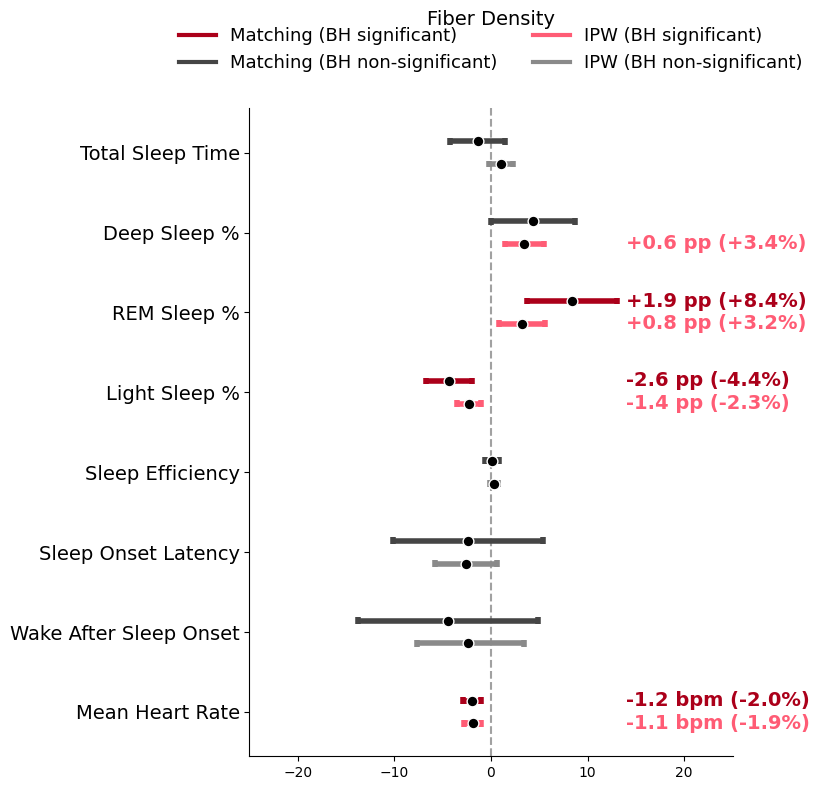

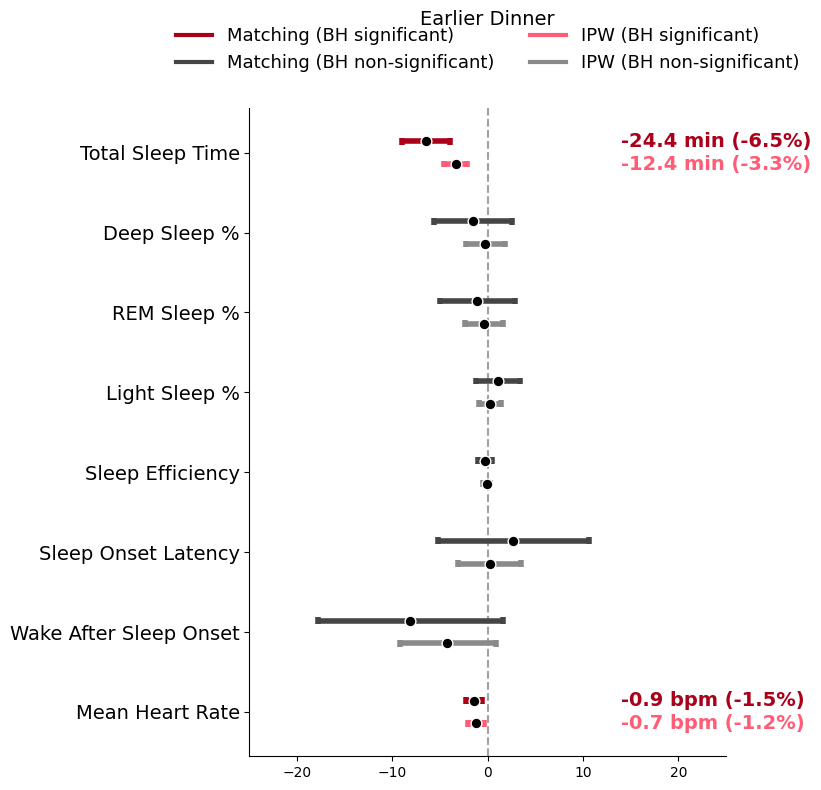

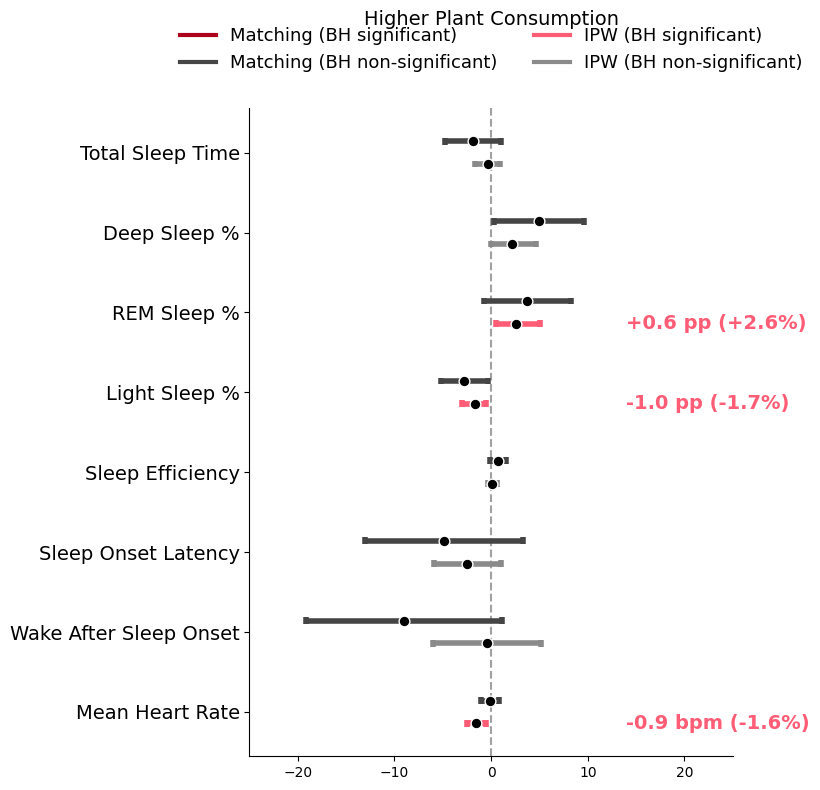

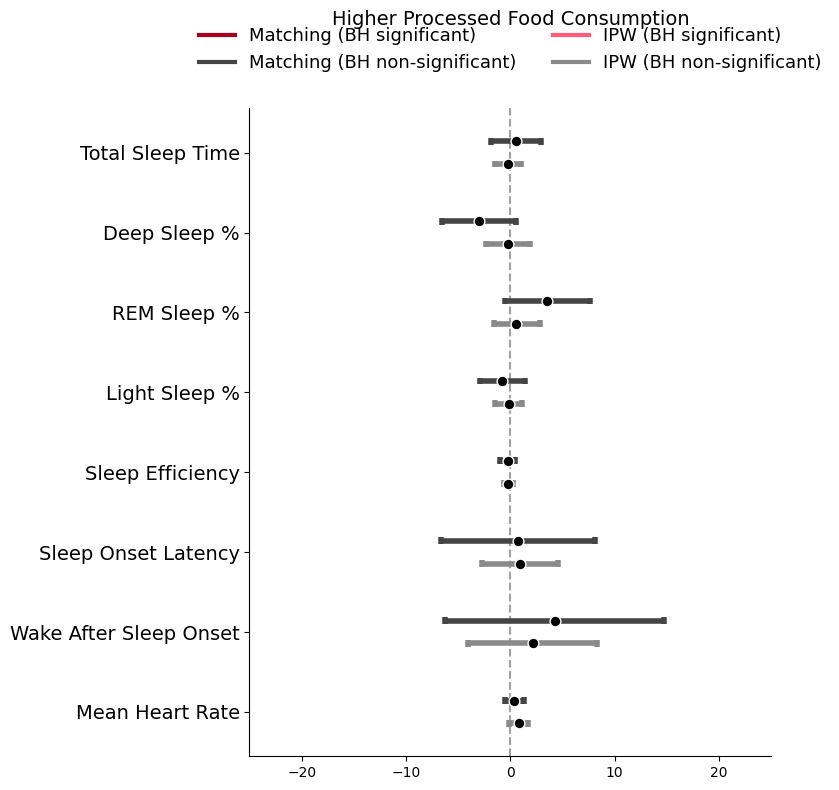

In [3]:
columns = [
    'fiber_density_energy',
    'hours_to_sleep',
    'plant_based_whole_foods_ratio',
    'processed_categories_ratio',
]

for c in columns:
    fig, ax = plot_combined_matching_ipw_results(
        c, 
        labels_dict=labels_dict,
        annotation_dict=annotation_dict,
        diet_full_names_mapping=diet_full_names_mapping
        )
    fig.show()